# Prediction of Gross

### Loading data set cleaned

In [60]:
import ast
import pandas as pd
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [61]:
import os
from urllib.request import urlretrieve

def download_dataset():

    urls = [
        ("1_zkibYlJyj5ZkLulFYtJ4_vp9RtgoUtW",
        "cleaned_film_datset.csv"),
    ]

    for (fileId, filename) in urls:
        urlretrieve(f"https://drive.usercontent.google.com/download?id={fileId}&export=download&authuser=1&confirm=t", f"./{filename}")

download_dataset()

In [62]:
movies_df = pd.read_csv("cleaned_film_datset.csv")
movies_df.drop(columns=['genre_imdb','spoken_languages','description_tmdb','Unnamed: 0','genre_letterboxd', 'imdb_id', 'original_language','description_letterboxd','tmdb_id','description_imdb'], inplace=True)

In [63]:
pd.set_option('display.max_columns', None)

### Adjustment of features for data vizualization for correlation and adjustment for data  prediction

Making sure it has the right format


In [64]:
movies_df['year']=movies_df['year'].astype(int)
movies_df['runtime']=movies_df['runtime'].astype(int)
movies_df['gross']=movies_df['gross'].astype(int)
movies_df['revenue']=movies_df['revenue'].astype(int)
movies_df['budget']=movies_df['budget'].astype(int)
movies_df['vote_count_letterboxd']=movies_df['vote_count_letterboxd'].astype(int)
movies_df['vote_count_imdb']=movies_df['vote_count_imdb'].astype(int)
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'])

Separate information with comas into new columns:


*   Director
*   Stars
*   Main genre




In [65]:
def extract_ids(column):
    return column.str.extractall('nm(\d+)/').groupby(level=0).agg(','.join)[0]

movies_df['main_genre'] = movies_df['genre_tmdb'].apply(lambda x: x.split(',')[0] if pd.notnull(x) else None)

movies_df['main_director'] = movies_df['director'].apply(lambda x: x.split(',')[0] if pd.notnull(x) else None)
movies_df['director_ids'] = extract_ids(movies_df['director_id'])

movies_df[['first_star', 'second_star']] = movies_df['star'].str.split(',', n=2, expand=True)[[0, 1]]
movies_df['second_star'] = movies_df['second_star'].str.replace('\n', '', regex=False)
movies_df['star_ids'] = extract_ids(movies_df['star_id'])

movies_df[[f'star_id_{i}' for i in range(4)]] = movies_df['star_ids'].str.split(',', expand=True, n=3)  # only starts have more than 1 ID, not directors

movies_df.drop(columns=['adult','genre_tmdb','director','star', 'star_ids','star_id_2', 'star_id_3','star_id','director_id'], inplace=True)
#movies_df.head()

Convert the text string of the production countries column to a Python list

In [66]:
movies_df['production_countries'] = movies_df['production_countries'].apply(ast.literal_eval)

max_countries = movies_df['production_countries'].apply(len).max()

for i in range(max_countries):
    col_name = f'country_{i+1}'
    movies_df[col_name] = movies_df['production_countries'].apply(lambda x: x[i] if i < len(x) else None)

movies_df = movies_df.drop(columns=[f'country_{i}' for i in range(2, max_countries+1)])
movies_df.drop('production_countries', axis=1, inplace=True, errors='ignore')
movies_df.rename(columns={'country_1': 'production_country'}, inplace=True)
movies_df.head()

,title,popularity,release_date,rating_letterboxd,vote_count_letterboxd,year,rating_imdb,vote_count_imdb,gross,revenue,runtime,budget,production_companies,main_genre,main_director,director_ids,first_star,second_star,star_id_0,star_id_1,production_country
0,The Christine Jorgensen Story,1.708,1970-10-29,4.2,5,1970,5.5,373,237000,0,98,0,Edward Small Productions,Drama,Irving Rapper,0710924,John Hansen,Joan Tompkins,0360896,0867000,United States of America
1,Say It Isn't So,7.182,2001-03-10,4.8,124,2001,5.0,13462,5516708,12320393,95,25000000,"Say It Isn't So Productions, Conundrum Enterta...",Comedy,J.B. Rogers,0736930,Chris Klein,Heather Graham,0005098,0001287,United States of America
2,Killers,22.918,2010-06-04,5.9,1819,2010,5.4,93114,47059963,98159963,100,75000000,"Katalyst Films, Lionsgate, Aversano Films",Action,Robert Luketic,0525659,Katherine Heigl,Ashton Kutcher,0001337,0005110,United States of America
3,In the Shadow of Women,2.636,2015-05-14,6.0,37,2015,6.5,1496,50291,54985,73,0,"SBS Productions, ARTE France Cinéma, Close Up ...",Drama,Philippe Garrel,0308042,Clotilde Courau,Stanislas Merhar,0183660,0580720,Switzerland
4,The Pope of Greenwich Village,5.630,1984-06-22,6.5,91,1984,6.6,9212,6139896,6836201,121,8000000,United Artists,Action,Stuart Rosenberg,0742341,Eric Roberts,Mickey Rourke,0000616,0000620,United States of America



Separate companies by commas and get only the first one

In [67]:
movies_df['production_companies'] = movies_df['production_companies'].apply(lambda x: x.split(',')[0] if pd.notnull(x) else None)
#movies_df.head()

Get months and season from released dates

In [68]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

movies_df['season'] = movies_df['release_date'].dt.month.apply(get_season)
movies_df= movies_df.drop('release_date', axis=1)
movies_df.head()

,title,popularity,rating_letterboxd,vote_count_letterboxd,year,rating_imdb,vote_count_imdb,gross,revenue,runtime,budget,production_companies,main_genre,main_director,director_ids,first_star,second_star,star_id_0,star_id_1,production_country,season
0,The Christine Jorgensen Story,1.708,4.2,5,1970,5.5,373,237000,0,98,0,Edward Small Productions,Drama,Irving Rapper,0710924,John Hansen,Joan Tompkins,0360896,0867000,United States of America,Fall
1,Say It Isn't So,7.182,4.8,124,2001,5.0,13462,5516708,12320393,95,25000000,Say It Isn't So Productions,Comedy,J.B. Rogers,0736930,Chris Klein,Heather Graham,0005098,0001287,United States of America,Spring
2,Killers,22.918,5.9,1819,2010,5.4,93114,47059963,98159963,100,75000000,Katalyst Films,Action,Robert Luketic,0525659,Katherine Heigl,Ashton Kutcher,0001337,0005110,United States of America,Summer
3,In the Shadow of Women,2.636,6.0,37,2015,6.5,1496,50291,54985,73,0,SBS Productions,Drama,Philippe Garrel,0308042,Clotilde Courau,Stanislas Merhar,0183660,0580720,Switzerland,Spring
4,The Pope of Greenwich Village,5.630,6.5,91,1984,6.6,9212,6139896,6836201,121,8000000,United Artists,Action,Stuart Rosenberg,0742341,Eric Roberts,Mickey Rourke,0000616,0000620,United States of America,Summer


### Vizualization for correlation



In [69]:
fig = px.scatter(movies_df, x='budget', y='gross', trendline='ols')
fig.update_layout(title='Budget vs Gross')
fig.show()

In [70]:
fig = px.scatter(movies_df, x='runtime', y='gross', trendline='ols')
fig.update_layout(title='Runtime vs Gross Revenue')
fig.show()

In [71]:
#movies_df[movies_df['gross'] > 200]
fig = px.scatter(movies_df, x='rating_imdb', y='gross', trendline='ols')
fig.update_layout(title='IMDB Rating vs Gross')
fig.show()

In [72]:
fig = px.line(movies_df[['year','gross']].groupby('year').mean().reset_index(), x='year', y='gross')
fig.update_layout(title='Average Gross Over Time')
fig.show()

In [73]:
seasonal_gross = movies_df.groupby(['year', 'season'])['gross'].mean().reset_index()

fig = px.line(seasonal_gross, x='year', y='gross', color='season',
              title='Average Gross for Season trough the years',
              labels={'year': 'Year', 'gross': 'Average Gross'},
              category_orders={"Season": ["Winter", "Spring", "Summer", "Fall"]})

fig.update_layout(xaxis_title='Year', yaxis_title='Average Gross', hovermode='x')

fig.show()

In [74]:
fig = px.bar(movies_df[['main_genre','gross']].groupby('main_genre').mean().reset_index(), x='main_genre', y='gross')
fig.update_layout(title='Primary Genre vs Gross', xaxis={'categoryorder':'total descending'})
fig.show()

In [75]:
fig = px.pie(movies_df['main_genre'], names='main_genre')
fig.update_layout(title='Distribution of Primary Genre')
fig.show()

In [76]:
gross_by_director = movies_df.groupby('main_director')['gross'].sum().reset_index()

top_directors = gross_by_director.sort_values('gross', ascending=False).head(20)

df_top_directors = movies_df[movies_df['main_director'].isin(top_directors['main_director'])]

fig = px.scatter(df_top_directors,
                 x='budget',
                 y='gross',
                 color='main_director',  # Color by director to differentiate them
                 size='gross',  # Use 'gross' as bubble size to highlight top-grossing movies
                 hover_name='main_director',  #Shows the director's name when you mouse over the bubble
                 title='Top 20 Directors by Gross: Gross vs. Budget')

fig.update_layout(xaxis_title='Budget', yaxis_title='Gross', legend_title='Top 20 Directors by Gross')
fig.show()

In [77]:
director_counts = movies_df.groupby('main_director').agg({'gross': 'sum', 'title': 'count'}).reset_index()

director_counts.columns = ['main_director', 'total_gross', 'movie_count']

top_directors = director_counts.sort_values('total_gross', ascending=False).head(20)

fig = px.scatter(top_directors,
                 x='movie_count',
                 y='total_gross',
                 size='total_gross',
                 color='main_director',
                 hover_name='main_director',
                 title='Top 20 Directors: Number of movies vs. Gross Total')

fig.update_layout(xaxis_title='Number of movies', yaxis_title='Gross Total', legend_title='Director')
fig.show()

In [78]:
actor_stats = movies_df.groupby('first_star').agg({'gross': 'sum', 'budget': 'sum', 'title': 'count'}).reset_index()

actor_stats.columns = ['star', 'total_gross', 'total_budget', 'movie_count']

top_actors = actor_stats.sort_values('total_gross', ascending=False).head(50)

fig = px.scatter(top_actors,
                 x='total_budget',
                 y='total_gross',
                 size='movie_count',
                 color='star',
                 hover_name='star',
                 title='Top 50 1- Actors: Gross Total vs. Budget Total')

fig.update_layout(xaxis_title='Budget Total', yaxis_title='Gross Total', legend_title='Actor')

fig.show()

In [79]:
fig = px.scatter(top_actors,
                 x='movie_count',
                 y='total_gross',
                 size='movie_count',
                 color='star',
                 hover_name='star',
                 title='Top 50 1- Actors: Gross Total vs. Number of Appearances')

fig.update_layout(xaxis_title='Number of Appearances', yaxis_title='Gross Total', legend_title='Actor')
fig.show()

In [80]:
actor_stats = movies_df.groupby('second_star').agg({'gross': 'sum', 'budget': 'sum', 'title': 'count'}).reset_index()

actor_stats.columns = ['star', 'total_gross', 'total_budget', 'movie_count']

top_actors = actor_stats.sort_values('total_gross', ascending=False).head(50)

fig = px.scatter(top_actors,
                 x='total_budget',
                 y='total_gross',
                 size='movie_count',
                 color='star',
                 hover_name='star',
                 title='Top 50 2- Actors: Gross Total vs. Budget Total')

fig.update_layout(xaxis_title='Budget Total', yaxis_title='Gross Total', legend_title='Actor')

fig.show()

In [81]:
fig = px.scatter(top_actors,
                 x='movie_count',
                 y='total_gross',
                 size='movie_count',
                 color='star',
                 hover_name='star',
                 title='Top 50 2- Actors: Gross Total vs. Number of Appearances')

fig.update_layout(xaxis_title='Number of Appearances', yaxis_title='Gross Total', legend_title='Actor')
fig.show()

### Adjust features for data predictions

Add inflation to the data frame

In [82]:
pip install cpi

In [83]:
import cpi

def adjust_for_inflation(amount, year):
    try:
        return cpi.inflate(amount, year)
    except:
        return amount

movies_df['gross_adjusted'] = movies_df.apply(lambda x: adjust_for_inflation(x['gross'], x['year']), axis=1)
movies_df['budget_adjusted'] = movies_df.apply(lambda x: adjust_for_inflation(x['budget'], x['year']), axis=1)
movies_df['revenue_adjusted'] = movies_df.apply(lambda x: adjust_for_inflation(x['revenue'], x['year']), axis=1)

In [84]:
movies_df[['year','budget', 'gross','revenue','budget_adjusted', 'gross_adjusted','revenue_adjusted']].head()

,year,budget,gross,revenue,budget_adjusted,gross_adjusted,revenue_adjusted
0,1970,0,237000,0,0.000000e+00,1.861195e+06,0.000000e+00
1,2001,25000000,5516708,12320393,4.301270e+07,9.491541e+06,2.119734e+07
2,2010,75000000,47059963,98159963,1.048017e+08,6.575955e+07,1.371645e+08
3,2015,0,50291,54985,0.000000e+00,6.465261e+04,7.068708e+04
4,1984,8000000,6139896,6836201,2.346117e+07,1.800615e+07,2.004816e+07


In [85]:
movies_df.drop(columns=['budget','gross','revenue'], inplace=True)

Add weigth rating

In [86]:
movies_df['Weighted_Rating'] = ((movies_df['rating_letterboxd'] * movies_df['vote_count_letterboxd']) +
                                (movies_df['rating_imdb'] * movies_df['vote_count_imdb'])) / (movies_df['vote_count_letterboxd'] + movies_df['vote_count_imdb'])

movies_df[['rating_letterboxd', 'vote_count_letterboxd', 'rating_imdb', 'vote_count_imdb', 'Weighted_Rating']].head()

,rating_letterboxd,vote_count_letterboxd,rating_imdb,vote_count_imdb,Weighted_Rating
0,4.2,5,5.5,373,5.482804
1,4.8,124,5.0,13462,4.998175
2,5.9,1819,5.4,93114,5.409580
3,6.0,37,6.5,1496,6.487932
4,6.5,91,6.6,9212,6.599022


In [87]:
movies_df.drop(columns=['rating_letterboxd', 'vote_count_letterboxd', 'rating_imdb', 'vote_count_imdb'], inplace=True)

HOT ENCODING


*Genre hot encoding*

In [88]:
genre_dummies = pd.get_dummies(movies_df['main_genre']).astype(int)
movies_encoded = pd.concat([movies_df.drop('main_genre', axis=1), genre_dummies], axis=1)
movies_encoded.head()

,title,popularity,year,runtime,production_companies,main_director,director_ids,first_star,second_star,star_id_0,star_id_1,production_country,season,gross_adjusted,budget_adjusted,revenue_adjusted,Weighted_Rating,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
0,The Christine Jorgensen Story,1.708,1970,98,Edward Small Productions,Irving Rapper,0710924,John Hansen,Joan Tompkins,0360896,0867000,United States of America,Fall,1.861195e+06,0.000000e+00,0.000000e+00,5.482804,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,Say It Isn't So,7.182,2001,95,Say It Isn't So Productions,J.B. Rogers,0736930,Chris Klein,Heather Graham,0005098,0001287,United States of America,Spring,9.491541e+06,4.301270e+07,2.119734e+07,4.998175,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Killers,22.918,2010,100,Katalyst Films,Robert Luketic,0525659,Katherine Heigl,Ashton Kutcher,0001337,0005110,United States of America,Summer,6.575955e+07,1.048017e+08,1.371645e+08,5.409580,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,In the Shadow of Women,2.636,2015,73,SBS Productions,Philippe Garrel,0308042,Clotilde Courau,Stanislas Merhar,0183660,0580720,Switzerland,Spring,6.465261e+04,0.000000e+00,7.068708e+04,6.487932,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,The Pope of Greenwich Village,5.630,1984,121,United Artists,Stuart Rosenberg,0742341,Eric Roberts,Mickey Rourke,0000616,0000620,United States of America,Summer,1.800615e+07,2.346117e+07,2.004816e+07,6.599022,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Production Country Hot encoding; selection of the firts 20 countries

In [89]:
#movies_encoded['production_country'].unique()

In [90]:
top_countries= ["United States of America", "United Kingdom", "China","France","Russia","Japan", "India","Germany","Italy", "South Korea","Canada","Spain", "Hong Kong","Australia","New Zealand","Mexico","Belgium","Ireland","Sweden","Netherlands"]
movies_encoded['production_country'] = movies_encoded['production_country'].apply(lambda x: x if x in top_countries else 'Other Countries')
#movies_encoded['production_country'].head()

In [91]:
country_dummies = pd.get_dummies(movies_encoded['production_country']).astype(int)
movies_encoded = pd.concat([movies_encoded.drop('production_country', axis=1), country_dummies], axis=1)
movies_encoded.head()

,title,popularity,year,runtime,production_companies,main_director,director_ids,first_star,second_star,star_id_0,star_id_1,season,gross_adjusted,budget_adjusted,revenue_adjusted,Weighted_Rating,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,Australia,Belgium,Canada,China,France,Germany,Hong Kong,India,Ireland,Italy,Japan,Mexico,Netherlands,New Zealand,Other Countries,Russia,South Korea,Spain,Sweden,United Kingdom,United States of America
0,The Christine Jorgensen Story,1.708,1970,98,Edward Small Productions,Irving Rapper,0710924,John Hansen,Joan Tompkins,0360896,0867000,Fall,1.861195e+06,0.000000e+00,0.000000e+00,5.482804,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Say It Isn't So,7.182,2001,95,Say It Isn't So Productions,J.B. Rogers,0736930,Chris Klein,Heather Graham,0005098,0001287,Spring,9.491541e+06,4.301270e+07,2.119734e+07,4.998175,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,Killers,22.918,2010,100,Katalyst Films,Robert Luketic,0525659,Katherine Heigl,Ashton Kutcher,0001337,0005110,Summer,6.575955e+07,1.048017e+08,1.371645e+08,5.409580,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,In the Shadow of Women,2.636,2015,73,SBS Productions,Philippe Garrel,0308042,Clotilde Courau,Stanislas Merhar,0183660,0580720,Spring,6.465261e+04,0.000000e+00,7.068708e+04,6.487932,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,The Pope of Greenwich Village,5.630,1984,121,United Artists,Stuart Rosenberg,0742341,Eric Roberts,Mickey Rourke,0000616,0000620,Summer,1.800615e+07,2.346117e+07,2.004816e+07,6.599022,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Directors hot-Encoding

In [92]:
# Supongamos que tienes un DataFrame llamado movies_encoded con una columna 'main_director'
# movies_encoded = ...

# Reemplazar "Anthony Russo" por "Russo Brothers"
movies_encoded['main_director'] = movies_encoded['main_director'].replace('Anthony Russo', 'Russo Brothers')

In [93]:
#movies_encoded['main_director'].unique()
import pandas as pd

# Supongamos que tienes un DataFrame llamado movies_encoded con una columna 'main_director'
# movies_encoded = ...

# Función para buscar coincidencias de un director en el DataFrame
def buscar_director(director):
    coincidencias = movies_encoded[movies_encoded['main_director'].str.contains(director, case=False)]
    if not coincidencias.empty:
        print("Coincidencias para el director", director, ":")
        print(coincidencias['main_director'].unique())
    else:
        print("No se encontraron coincidencias para el director", director)

# Pedir al usuario que ingrese el nombre del director
nombre_director = input("Ingrese una parte del nombre del director que desea buscar: ")

# Llamar a la función para buscar coincidencias
buscar_director(nombre_director)



Ingrese una parte del nombre del director que desea buscar: Quentin
Coincidencias para el director Quentin :
['Quentin Tarantino' 'Quentin Dupieux']


In [94]:
top_directors= ["Steven Spielberg", "James Cameron", "Russo Brothers", "Peter Jackson", "Michael Bay", "David Yates", "Christopher Nolan", "J.J. Abrams", "Ridley Scott", "Tim Burton", "Robert Zemeckis", "Jon Favreau", "Ron Howard", "Sam Raimi", "James Wan", "Chris Columbus", "Roland Emmerich", "Jon Watts", "Pierre Coffin"]
movies_encoded['main_director'] = movies_encoded['main_director'].apply(lambda x: x if x in top_directors else 'Other Directors')
movies_encoded

,title,popularity,year,runtime,production_companies,main_director,director_ids,first_star,second_star,star_id_0,star_id_1,season,gross_adjusted,budget_adjusted,revenue_adjusted,Weighted_Rating,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,Australia,Belgium,Canada,China,France,Germany,Hong Kong,India,Ireland,Italy,Japan,Mexico,Netherlands,New Zealand,Other Countries,Russia,South Korea,Spain,Sweden,United Kingdom,United States of America
0,The Christine Jorgensen Story,1.708,1970,98,Edward Small Productions,Other Directors,0710924,John Hansen,Joan Tompkins,0360896,0867000,Fall,1.861195e+06,0.000000e+00,0.000000e+00,5.482804,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Say It Isn't So,7.182,2001,95,Say It Isn't So Productions,Other Directors,0736930,Chris Klein,Heather Graham,0005098,0001287,Spring,9.491541e+06,4.301270e+07,2.119734e+07,4.998175,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,Killers,22.918,2010,100,Katalyst Films,Other Directors,0525659,Katherine Heigl,Ashton Kutcher,0001337,0005110,Summer,6.575955e+07,1.048017e+08,1.371645e+08,5.409580,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,In the Shadow of Women,2.636,2015,73,SBS Productions,Other Directors,0308042,Clotilde Courau,Stanislas Merhar,0183660,0580720,Spring,6.465261e+04,0.000000e+00,7.068708e+04,6.487932,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,The Pope of Greenwich Village,5.630,1984,121,United Artists,Other Directors,0742341,Eric Roberts,Mickey Rourke,0000616,0000620,Summer,1.800615e+07,2.346117e+07,2.004816e+07,6.599022,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11235,Baptists at Our Barbecue,4.421,2004,92,Halestorm Entertainment,Other Directors,1151613,Steve Anderson,Heather Beers,0027468,1235592,Fall,2.792258e+05,8.065167e+05,2.795484e+05,5.493840,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
11236,School of Life,8.828,2017,116,StudioCanal,Other Directors,1534640,François Cluzet,Jean Scandel,0167388,8921535,Winter,7.831359e+03,0.000000e+00,0.000000e+00,6.970368,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11237,Jujutsu Kaisen 0,139.128,2021,105,MAPPA,Other Directors,4810022,Chinatsu Akasaki,Aya Endô,4533533,2594314,Winter,3.884285e+07,0.000000e+00,2.202541e+08,7.800212,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
11238,Price of Glory,2.634,2000,118,New Line Cinema,Other Directors,0959665,Jimmy Smits,Maria del Mar,0001751,0544691,Spring,6.077257e+06,1.769466e+07,0.000000e+00,6.089787,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [95]:
director_dummies = pd.get_dummies(movies_encoded['main_director']).astype(int)
movies_encoded = pd.concat([movies_encoded.drop('main_director', axis=1), director_dummies], axis=1)
movies_encoded

,title,popularity,year,runtime,production_companies,director_ids,first_star,second_star,star_id_0,star_id_1,season,gross_adjusted,budget_adjusted,revenue_adjusted,Weighted_Rating,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,Australia,Belgium,Canada,China,France,Germany,Hong Kong,India,Ireland,Italy,Japan,Mexico,Netherlands,New Zealand,Other Countries,Russia,South Korea,Spain,Sweden,United Kingdom,United States of America,Chris Columbus,Christopher Nolan,David Yates,J.J. Abrams,James Cameron,James Wan,Jon Favreau,Jon Watts,Michael Bay,Other Directors,Peter Jackson,Pierre Coffin,Ridley Scott,Robert Zemeckis,Roland Emmerich,Ron Howard,Russo Brothers,Sam Raimi,Steven Spielberg,Tim Burton
0,The Christine Jorgensen Story,1.708,1970,98,Edward Small Productions,0710924,John Hansen,Joan Tompkins,0360896,0867000,Fall,1.861195e+06,0.000000e+00,0.000000e+00,5.482804,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Say It Isn't So,7.182,2001,95,Say It Isn't So Productions,0736930,Chris Klein,Heather Graham,0005098,0001287,Spring,9.491541e+06,4.301270e+07,2.119734e+07,4.998175,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,Killers,22.918,2010,100,Katalyst Films,0525659,Katherine Heigl,Ashton Kutcher,0001337,0005110,Summer,6.575955e+07,1.048017e+08,1.371645e+08,5.409580,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,In the Shadow of Women,2.636,2015,73,SBS Productions,0308042,Clotilde Courau,Stanislas Merhar,0183660,0580720,Spring,6.465261e+04,0.000000e+00,7.068708e+04,6.487932,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,The Pope of Greenwich Village,5.630,1984,121,United Artists,0742341,Eric Roberts,Mickey Rourke,0000616,0000620,Summer,1.800615e+07,2.346117e+07,2.004816e+07,6.599022,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11235,Baptists at Our Barbecue,4.421,2004,92,Halestorm Entertainment,1151613,Steve Anderson,Heather Beers,0027468,1235592,Fall,2.792258e+05,8.065167e+05,2.795484e+05,5.493840,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
11236,School of Life,8.828,2017,116,StudioCanal,1534640,François Cluzet,Jean Scandel,0167388,8921535,Winter,7.831359e+03,0.000000e+00,0.000000e+00,6.970368,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
11237,Jujutsu Kaisen 0,139.128,2021,105,MAPPA,4810022,Chinatsu Akasaki,Aya Endô,4533533,2594314,Winter,3.884285e+07,0.000000e+00,2.202541e+08,7.800212,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
11238,Price of Glory,2.634,2000,118,New Line Cinema,0959665,Jimmy Smits,Maria del Mar,0001751,0544691,Spring,6.077257e+06,1.769466e+07,0.000000e+00,6.089787,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


## Actors Hot-Encoding

In [96]:
import pandas as pd

# Supongamos que tienes un DataFrame llamado movies_encoded con una columna 'first_star'
# movies_encoded = ...

# Función para buscar coincidencias de un actor en el DataFrame
def buscar_actor(actor):
    coincidencias = movies_encoded[movies_encoded['first_star'].str.contains(actor, case=False)]
    if not coincidencias.empty:
        print("Coincidencias para el actor", actor, ":")
        print(coincidencias['first_star'].unique())
    else:
        print("No se encontraron coincidencias para el actor", actor)

# Pedir al usuario que ingrese el nombre de un actor
nombre_actor = input("Ingrese una parte del nombre del actor que desea buscar: ")

# Llamar a la función para buscar coincidencias
buscar_actor(nombre_actor)

Ingrese una parte del nombre del actor que desea buscar: Leo
Coincidencias para el actor Leo :
['Leonardo DiCaprio' 'Marco Leonardi' 'Leo Morimoto' 'Leonard Whiting'
 'Leopold Stokowski' 'Louie Leonardo' 'Stephanie Leonidas' 'Melissa Leo'
 'Leon Isaac Kennedy' 'Gustav Leonhardt' 'Leo Fong' 'Leonor Silveira'
 'Leo Fafard' 'Leonor Watling' 'Robert Sean Leonard' 'Leo Grillo'
 'Gavin MacLeod' 'Leon Ames' 'Leo Bassi' 'Eleonora Rossi Drago'
 'Leonard Mann' 'Leonid Filatov']


In [97]:
import pandas as pd
top_actores= ["Samuel L. Jackson", "Scarlett Johansson", "Robert Downey Jr.", "Zoe Saldana", "Chris Pratt", "Tom Cruise", "Vin Diesel", "Chris Hemsworth", "Bradley Cooper", "Chris Evans", "Tom Hanks", "Johnny Depp", "Dwayne Johnson", "Tom Holland", "Mark Ruffalo", "Emma Watson", "Don Cheadle", "Jeremy Renner", "Dave Bautista", "Will Smith", "Karen Gillan", "Elizabeth Olsen", "Josh Brolin", "Daniel Radcliffe", "Benedict Cumberbatch", "Harrison Ford", "Chadwick Boseman", "Rupert Grint", "Letitia Wright", "Leonardo DiCaprio", "Steve Carell", "Sebastian Stan", "Matt Damon", "Danai Gurira", "Tom Hiddleston", "Brad Pitt", "Paul Bettany", "Bruce Willis", "Jack Black", "Eddie Murphy", "Liam Neeson", "Pom Klementieff", "Benedict Wong", "Sam Worthington", "Ben Stiller", "Hugh Jackman", "Jason Statham", "Ian McKellen", "Gwyneth Paltrow", "Jennifer Lawrence", "Mark Wahlberg", "Nicolas Cage", "Cameron Diaz", "Ewan McGregor", "Christian Bale", "Jim Carrey", "Idris Elba", "Natalie Portman", "Paul Rudd", "Brie Larson", "Josh Gad", "Julia Roberts", "Sandra Bullock", "Martin Freeman", "Adam Sandler", "Keanu Reeves", "Robert De Niro", "Sylvester Stallone", "Ben Affleck", "Ralph Fiennes", "Ryan Reynolds", "Owen Wilson", "Adam Driver", "Michelle Rodriguez", "Daniel Craig", "Daisy Ridley", "Orlando Bloom", "Morgan Freeman", "John Boyega", "Robin Williams", "Mel Gibson", "George Clooney", "Will Ferrell", "Kevin Hart", "Robert Pattinson", "Simon Pegg", "Lupita Nyong'o", "Arnold Schwarzenegger", "Shia LaBeouf", "Denzel Washington", "Evangeline Lilly", "Meryl Streep", "Anthony Mackie", "Jude Law", "Jon Favreau", "Mark Hamill", "Anthony Hopkins", "Keegan-Michael Key", "Channing Tatum", "Russell Crowe"]
movies_encoded['first_star'] = movies_encoded['first_star'].apply(lambda x: x if x in top_actores else 'Other actors')
movies_encoded


,title,popularity,year,runtime,production_companies,director_ids,first_star,second_star,star_id_0,star_id_1,season,gross_adjusted,budget_adjusted,revenue_adjusted,Weighted_Rating,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,Australia,Belgium,Canada,China,France,Germany,Hong Kong,India,Ireland,Italy,Japan,Mexico,Netherlands,New Zealand,Other Countries,Russia,South Korea,Spain,Sweden,United Kingdom,United States of America,Chris Columbus,Christopher Nolan,David Yates,J.J. Abrams,James Cameron,James Wan,Jon Favreau,Jon Watts,Michael Bay,Other Directors,Peter Jackson,Pierre Coffin,Ridley Scott,Robert Zemeckis,Roland Emmerich,Ron Howard,Russo Brothers,Sam Raimi,Steven Spielberg,Tim Burton
0,The Christine Jorgensen Story,1.708,1970,98,Edward Small Productions,0710924,Other actors,Joan Tompkins,0360896,0867000,Fall,1.861195e+06,0.000000e+00,0.000000e+00,5.482804,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Say It Isn't So,7.182,2001,95,Say It Isn't So Productions,0736930,Other actors,Heather Graham,0005098,0001287,Spring,9.491541e+06,4.301270e+07,2.119734e+07,4.998175,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,Killers,22.918,2010,100,Katalyst Films,0525659,Other actors,Ashton Kutcher,0001337,0005110,Summer,6.575955e+07,1.048017e+08,1.371645e+08,5.409580,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,In the Shadow of Women,2.636,2015,73,SBS Productions,0308042,Other actors,Stanislas Merhar,0183660,0580720,Spring,6.465261e+04,0.000000e+00,7.068708e+04,6.487932,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,The Pope of Greenwich Village,5.630,1984,121,United Artists,0742341,Other actors,Mickey Rourke,0000616,0000620,Summer,1.800615e+07,2.346117e+07,2.004816e+07,6.599022,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11235,Baptists at Our Barbecue,4.421,2004,92,Halestorm Entertainment,1151613,Other actors,Heather Beers,0027468,1235592,Fall,2.792258e+05,8.065167e+05,2.795484e+05,5.493840,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
11236,School of Life,8.828,2017,116,StudioCanal,1534640,Other actors,Jean Scandel,0167388,8921535,Winter,7.831359e+03,0.000000e+00,0.000000e+00,6.970368,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
11237,Jujutsu Kaisen 0,139.128,2021,105,MAPPA,4810022,Other actors,Aya Endô,4533533,2594314,Winter,3.884285e+07,0.000000e+00,2.202541e+08,7.800212,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
11238,Price of Glory,2.634,2000,118,New Line Cinema,0959665,Other actors,Maria del Mar,0001751,0544691,Spring,6.077257e+06,1.769466e+07,0.000000e+00,6.089787,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [98]:
import pandas as pd
top_actores= ["Samuel L. Jackson", "Scarlett Johansson", "Robert Downey Jr.", "Zoe Saldana", "Chris Pratt", "Tom Cruise", "Vin Diesel", "Chris Hemsworth", "Bradley Cooper", "Chris Evans", "Tom Hanks", "Johnny Depp", "Dwayne Johnson", "Tom Holland", "Mark Ruffalo", "Emma Watson", "Don Cheadle", "Jeremy Renner", "Dave Bautista", "Will Smith", "Karen Gillan", "Elizabeth Olsen", "Josh Brolin", "Daniel Radcliffe", "Benedict Cumberbatch", "Harrison Ford", "Chadwick Boseman", "Rupert Grint", "Letitia Wright", "Leonardo DiCaprio", "Steve Carell", "Sebastian Stan", "Matt Damon", "Danai Gurira", "Tom Hiddleston", "Brad Pitt", "Paul Bettany", "Bruce Willis", "Jack Black", "Eddie Murphy", "Liam Neeson", "Pom Klementieff", "Benedict Wong", "Sam Worthington", "Ben Stiller", "Hugh Jackman", "Jason Statham", "Ian McKellen", "Gwyneth Paltrow", "Jennifer Lawrence", "Mark Wahlberg", "Nicolas Cage", "Cameron Diaz", "Ewan McGregor", "Christian Bale", "Jim Carrey", "Idris Elba", "Natalie Portman", "Paul Rudd", "Brie Larson", "Josh Gad", "Julia Roberts", "Sandra Bullock", "Martin Freeman", "Adam Sandler", "Keanu Reeves", "Robert De Niro", "Sylvester Stallone", "Ben Affleck", "Ralph Fiennes", "Ryan Reynolds", "Owen Wilson", "Adam Driver", "Michelle Rodriguez", "Daniel Craig", "Daisy Ridley", "Orlando Bloom", "Morgan Freeman", "John Boyega", "Robin Williams", "Mel Gibson", "George Clooney", "Will Ferrell", "Kevin Hart", "Robert Pattinson", "Simon Pegg", "Lupita Nyong'o", "Arnold Schwarzenegger", "Shia LaBeouf", "Denzel Washington", "Evangeline Lilly", "Meryl Streep", "Anthony Mackie", "Jude Law", "Jon Favreau", "Mark Hamill", "Anthony Hopkins", "Keegan-Michael Key", "Channing Tatum", "Russell Crowe"]
movies_encoded['second_star'] = movies_encoded['second_star'].apply(lambda x: x if x in top_actores else 'Other actors')
movies_encoded

,title,popularity,year,runtime,production_companies,director_ids,first_star,second_star,star_id_0,star_id_1,season,gross_adjusted,budget_adjusted,revenue_adjusted,Weighted_Rating,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,Australia,Belgium,Canada,China,France,Germany,Hong Kong,India,Ireland,Italy,Japan,Mexico,Netherlands,New Zealand,Other Countries,Russia,South Korea,Spain,Sweden,United Kingdom,United States of America,Chris Columbus,Christopher Nolan,David Yates,J.J. Abrams,James Cameron,James Wan,Jon Favreau,Jon Watts,Michael Bay,Other Directors,Peter Jackson,Pierre Coffin,Ridley Scott,Robert Zemeckis,Roland Emmerich,Ron Howard,Russo Brothers,Sam Raimi,Steven Spielberg,Tim Burton
0,The Christine Jorgensen Story,1.708,1970,98,Edward Small Productions,0710924,Other actors,Other actors,0360896,0867000,Fall,1.861195e+06,0.000000e+00,0.000000e+00,5.482804,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Say It Isn't So,7.182,2001,95,Say It Isn't So Productions,0736930,Other actors,Other actors,0005098,0001287,Spring,9.491541e+06,4.301270e+07,2.119734e+07,4.998175,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,Killers,22.918,2010,100,Katalyst Films,0525659,Other actors,Other actors,0001337,0005110,Summer,6.575955e+07,1.048017e+08,1.371645e+08,5.409580,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,In the Shadow of Women,2.636,2015,73,SBS Productions,0308042,Other actors,Other actors,0183660,0580720,Spring,6.465261e+04,0.000000e+00,7.068708e+04,6.487932,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,The Pope of Greenwich Village,5.630,1984,121,United Artists,0742341,Other actors,Other actors,0000616,0000620,Summer,1.800615e+07,2.346117e+07,2.004816e+07,6.599022,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11235,Baptists at Our Barbecue,4.421,2004,92,Halestorm Entertainment,1151613,Other actors,Other actors,0027468,1235592,Fall,2.792258e+05,8.065167e+05,2.795484e+05,5.493840,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
11236,School of Life,8.828,2017,116,StudioCanal,1534640,Other actors,Other actors,0167388,8921535,Winter,7.831359e+03,0.000000e+00,0.000000e+00,6.970368,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
11237,Jujutsu Kaisen 0,139.128,2021,105,MAPPA,4810022,Other actors,Other actors,4533533,2594314,Winter,3.884285e+07,0.000000e+00,2.202541e+08,7.800212,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
11238,Price of Glory,2.634,2000,118,New Line Cinema,0959665,Other actors,Other actors,0001751,0544691,Spring,6.077257e+06,1.769466e+07,0.000000e+00,6.089787,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [99]:
# Fusionar las columnas first_star y second_star en una sola columna
movies_encoded['combined_stars'] = movies_encoded['first_star'] + ' ' + movies_encoded['second_star']

# Eliminar los valores duplicados de la columna combinada
movies_encoded['combined_stars'] = movies_encoded['combined_stars'].apply(lambda x: ' '.join(sorted(set(x.split()), key=x.split().index)))

# Eliminar las columnas originales first_star y second_star si es necesario
# movies_encoded.drop(['first_star', 'second_star'], axis=1, inplace=True)

In [100]:
# Realizar la operación de búsqueda y reemplazo en la columna combined_stars
movies_encoded['combined_stars'] = movies_encoded['combined_stars'].apply(lambda x: x.replace(' Other actors', '') if ' Other actors' in x else x)

In [101]:
actor_dummies = pd.get_dummies(movies_encoded['combined_stars']).astype(int)
movies_encoded = pd.concat([movies_encoded.drop('combined_stars', axis=1), actor_dummies], axis=1)
movies_encoded

,title,popularity,year,runtime,production_companies,director_ids,first_star,second_star,star_id_0,star_id_1,season,gross_adjusted,budget_adjusted,revenue_adjusted,Weighted_Rating,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,Australia,Belgium,Canada,China,France,Germany,Hong Kong,India,Ireland,Italy,Japan,Mexico,Netherlands,New Zealand,Other Countries,Russia,South Korea,Spain,Sweden,United Kingdom,United States of America,Chris Columbus,Christopher Nolan,David Yates,J.J. Abrams,James Cameron,James Wan,Jon Favreau,Jon Watts,Michael Bay,Other Directors,Peter Jackson,Pierre Coffin,Ridley Scott,Robert Zemeckis,Roland Emmerich,Ron Howard,Russo Brothers,Sam Raimi,Steven Spielberg,Tim Burton,Adam Driver,Adam Sandler,Anthony Hopkins,Anthony Mackie,Arnold Schwarzenegger,Ben Affleck,Ben Stiller,Benedict Cumberbatch,Brad Pitt,Bradley Cooper,Brie Larson,Bruce Willis,Cameron Diaz,Chadwick Boseman,Channing Tatum,Chris Evans,Chris Hemsworth,Chris Pratt,Christian Bale,Daisy Ridley,Daniel Craig,Daniel Radcliffe,Dave Bautista,Denzel Washington,Don Cheadle,Dwayne Johnson,Eddie Murphy,Elizabeth Olsen,Emma Watson,Ewan McGregor,George Clooney,Gwyneth Paltrow,Harrison Ford,Hugh Jackman,Ian McKellen,Idris Elba,Jack Black,Jason Statham,Jennifer Lawrence,Jeremy Renner,Jim Carrey,John Boyega,Johnny Depp,Jon Favreau,Josh Brolin,Josh Gad,Jude Law,Julia Roberts,Karen Gillan,Keanu Reeves,Keegan-Michael Key,Kevin Hart,Leonardo DiCaprio,Liam Neeson,Lupita Nyong'o,Mark Hamill,Mark Ruffalo,Mark Wahlberg,Martin Freeman,Matt Damon,Mel Gibson,Meryl Streep,Michelle Rodriguez,Morgan Freeman,Natalie Portman,Nicolas Cage,Orlando Bloom,Other actors,Owen Wilson,Paul Bettany,Paul Rudd,Ralph Fiennes,Robert De Niro,Robert Downey Jr.,Robert Pattinson,Robin Williams,Russell Crowe,Ryan Reynolds,Sam Worthington,Samuel L. Jackson,Sandra Bullock,Scarlett Johansson,Shia LaBeouf,Simon Pegg,Steve Carell,Sylvester Stallone,Tom Cruise,Tom Hanks,Tom Hiddleston,Tom Holland,Vin Diesel,Will Ferrell,Will Smith,Zoe Saldana
0,The Christine Jorgensen Story,1.708,1970,98,Edward Small Productions,0710924,Other actors,Other actors,0360896,0867000,Fall,1.861195e+06,0.000000e+00,0.000000e+00,5.482804,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Say It Isn't So,7.182,2001,95,Say It Isn't So Productions,0736930,Other actors,Other actors,0005098,0001287,Spring,9.491541e+06,4.301270e+07,2.119734e+07,4.998175,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Killers,22.918,2010,100,Katalyst Films,0525659,Other actors,Other actors,0001337,0005110,Summer,6.575955e+07,1.048017e+08,1.371645e+08,5.409580,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,In the Shadow of Women,2.636,2015,73,SBS Productions,0308042,Other actors,Other actors,0183660,0580720,Spring,6.465261e+04,0.000000e+00,7.068708e+04,6.487932,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,The Pope of Greenwich Village,5.6

## Production Companies Hot-Encoding

In [102]:
import pandas as pd

# Definir la función para reemplazar valores
def reemplazar_valores(df, valores_a_reemplazar):
    for nuevo_valor, valores in valores_a_reemplazar.items():
        df['production_companies'] = df['production_companies'].replace(valores, nuevo_valor)
    return df

# Supongamos que tienes un DataFrame llamado movies_encoded
# movies_encoded = ...

# Diccionario de valores a reemplazar para diferentes estudios
valores_a_reemplazar = {
    'Warner Bros': [
        'Warner Bros. Pictures',
        'Warner Bros. Korea',
        'Warner Bros. Television',
        'Warner Bros-Seven Arts',
        'Warner Bros. Animation',
        'Warner Bros. Family Entertainment',
        'Warner Bros. Pictures Animation',
        'Warner Bros. Entertainment España',
        'Warner Bros. Digital'
    ],
    'Universal Pictures': [
        'Universal Pictures',
        'Universal Pictures do Brasil',
        'Universal Pictures International (UPI)'
    ],
    'Columbia Pictures': [
        'Columbia Pictures',
        'Columbia Pictures Film Production Asia',
        'Columbia Pictures Producciones Mexico'
    ],
    'Paramount': [
        'Paramount',
        'Paramount Famous Lasky Corporation',
        'Paramount Players',
        'Paramount Animation',
        'Paramount Vantage',
        'Paramount Pictures Canada'
    ],
    '20th Century Fox': [
        '20th Century Fox',
        '20th Century Fox Animation',
        '20th Century Fox Home Entertainment',
        '20th Century Fox Argentina'
    ],
    'Dune Entertainment': [
        'Dune Entertainment',
        'Dune Entertainment III'
    ],
    'Metro-Goldwyn-Mayer': [
        'Metro-Goldwyn-Mayer',
        'Metro-Goldwyn Pictures Corporation'
    ],
    'Village Roadshow Pictures': [
        'Village Roadshow Pictures',
        'Village Roadshow Pictures Asia'
    ],
    'Walt Disney': [
        'Walt Disney Pictures',
        'Walt Disney Productions',
        'Walt Disney Animation Studios',
        'Walt Disney Animation',
        'Walt Disney Feature Animation'
    ],
    'Lionsgate': [
        'Lionsgate',
        'Lionsgate Home Entertainment'
    ],
    'Illumination': [
        'Illumination',
        'Illuminations Films'
    ]
}

# Reemplazar los valores para cada estudio
movies_encoded = reemplazar_valores(movies_encoded, valores_a_reemplazar)

In [103]:
import pandas as pd

# Supongamos que tienes un DataFrame llamado movies_encoded con una columna 'production_companies'
# movies_encoded = ...

# Función para buscar coincidencias de una compañía de producción en el DataFrame
def buscar_compania(compania):
    coincidencias = movies_encoded[movies_encoded['production_companies'].str.contains(compania, case=False)]
    if not coincidencias.empty:
        print("Coincidencias para la compañía de producción", compania, ":")
        print(coincidencias['production_companies'].unique())
    else:
        print("No se encontraron coincidencias para la compañía de producción", compania)

# Pedir al usuario que ingrese el nombre de una compañía de producción
nombre_compania = input("Ingrese una parte del nombre de la compañía de producción que desea buscar: ")

# Llamar a la función para buscar coincidencias
buscar_compania(nombre_compania)

Ingrese una parte del nombre de la compañía de producción que desea buscar: Fox
Coincidencias para la compañía de producción Fox :
['20th Century Fox' 'Fox Searchlight Pictures' 'Fox 2000 Pictures'
 'Fox Film Corporation' 'Fox Atomic' 'Fox Animation Studios' 'Greenfox'
 'Les Productions Fox Europa' 'Active Fox Productions' 'Uchovsky Fox']


In [104]:
#"Warner Bros", "Universal Pictures", "Columbia Pictures", "Paramount","20th Century Fox","Dune Entertainment", "Disney-Pixar", "Metro-Goldwyn-Mayer", "Village Roadshow Productions", "Walt Disney Animation Studios", "Lionsgate", "Illumination Entertainment",

In [105]:
top_company= ["Warner Bros", "Universal Pictures", "Columbia Pictures", "Marvel Studios", "Walt Disney Pictures", "Paramount Pictures", "20th Century Fox", "Legendary Pictures", "New Line Cinema", "DreamWorks Animation", "Dune Entertainment", "Amblin Entertainment", "Disney-Pixar", "Relativity Media", "Metro-Goldwyn-Mayer", "Village Roadshow Productions", "DreamWorks Pictures", "Heyday Films", "Regency Enterprises", "Lucasfilm Ltd.", "Walt Disney Animation Studios", "Lionsgate", "TSG Entertainment", "RatPac Entertainment", "Illumination Entertainment", "Original Film", "Skydance", "Summit Entertainment", "Touchstone Pictures", "di Bonaventura Pictures"]
movies_encoded['production_companies'] = movies_encoded['production_companies'].apply(lambda x: x if x in top_company else 'Other Companies')
movies_encoded

,title,popularity,year,runtime,production_companies,director_ids,first_star,second_star,star_id_0,star_id_1,season,gross_adjusted,budget_adjusted,revenue_adjusted,Weighted_Rating,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,Australia,Belgium,Canada,China,France,Germany,Hong Kong,India,Ireland,Italy,Japan,Mexico,Netherlands,New Zealand,Other Countries,Russia,South Korea,Spain,Sweden,United Kingdom,United States of America,Chris Columbus,Christopher Nolan,David Yates,J.J. Abrams,James Cameron,James Wan,Jon Favreau,Jon Watts,Michael Bay,Other Directors,Peter Jackson,Pierre Coffin,Ridley Scott,Robert Zemeckis,Roland Emmerich,Ron Howard,Russo Brothers,Sam Raimi,Steven Spielberg,Tim Burton,Adam Driver,Adam Sandler,Anthony Hopkins,Anthony Mackie,Arnold Schwarzenegger,Ben Affleck,Ben Stiller,Benedict Cumberbatch,Brad Pitt,Bradley Cooper,Brie Larson,Bruce Willis,Cameron Diaz,Chadwick Boseman,Channing Tatum,Chris Evans,Chris Hemsworth,Chris Pratt,Christian Bale,Daisy Ridley,Daniel Craig,Daniel Radcliffe,Dave Bautista,Denzel Washington,Don Cheadle,Dwayne Johnson,Eddie Murphy,Elizabeth Olsen,Emma Watson,Ewan McGregor,George Clooney,Gwyneth Paltrow,Harrison Ford,Hugh Jackman,Ian McKellen,Idris Elba,Jack Black,Jason Statham,Jennifer Lawrence,Jeremy Renner,Jim Carrey,John Boyega,Johnny Depp,Jon Favreau,Josh Brolin,Josh Gad,Jude Law,Julia Roberts,Karen Gillan,Keanu Reeves,Keegan-Michael Key,Kevin Hart,Leonardo DiCaprio,Liam Neeson,Lupita Nyong'o,Mark Hamill,Mark Ruffalo,Mark Wahlberg,Martin Freeman,Matt Damon,Mel Gibson,Meryl Streep,Michelle Rodriguez,Morgan Freeman,Natalie Portman,Nicolas Cage,Orlando Bloom,Other actors,Owen Wilson,Paul Bettany,Paul Rudd,Ralph Fiennes,Robert De Niro,Robert Downey Jr.,Robert Pattinson,Robin Williams,Russell Crowe,Ryan Reynolds,Sam Worthington,Samuel L. Jackson,Sandra Bullock,Scarlett Johansson,Shia LaBeouf,Simon Pegg,Steve Carell,Sylvester Stallone,Tom Cruise,Tom Hanks,Tom Hiddleston,Tom Holland,Vin Diesel,Will Ferrell,Will Smith,Zoe Saldana
0,The Christine Jorgensen Story,1.708,1970,98,Other Companies,0710924,Other actors,Other actors,0360896,0867000,Fall,1.861195e+06,0.000000e+00,0.000000e+00,5.482804,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Say It Isn't So,7.182,2001,95,Other Companies,0736930,Other actors,Other actors,0005098,0001287,Spring,9.491541e+06,4.301270e+07,2.119734e+07,4.998175,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Killers,22.918,2010,100,Other Companies,0525659,Other actors,Other actors,0001337,0005110,Summer,6.575955e+07,1.048017e+08,1.371645e+08,5.409580,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,In the Shadow of Women,2.636,2015,73,Other Companies,0308042,Other actors,Other actors,0183660,0580720,Spring,6.465261e+04,0.000000e+00,7.068708e+04,6.487932,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,The Pope of Greenwich Village,5.630,1984,121,Other Co

In [106]:
company_dummies = pd.get_dummies(movies_encoded['production_companies']).astype(int)
movies_encoded = pd.concat([movies_encoded.drop('production_companies', axis=1), company_dummies], axis=1)
movies_encoded

,title,popularity,year,runtime,director_ids,first_star,second_star,star_id_0,star_id_1,season,gross_adjusted,budget_adjusted,revenue_adjusted,Weighted_Rating,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,Australia,Belgium,Canada,China,France,Germany,Hong Kong,India,Ireland,Italy,Japan,Mexico,Netherlands,New Zealand,Other Countries,Russia,South Korea,Spain,Sweden,United Kingdom,United States of America,Chris Columbus,Christopher Nolan,David Yates,J.J. Abrams,James Cameron,James Wan,Jon Favreau,Jon Watts,Michael Bay,Other Directors,Peter Jackson,Pierre Coffin,Ridley Scott,Robert Zemeckis,Roland Emmerich,Ron Howard,Russo Brothers,Sam Raimi,Steven Spielberg,Tim Burton,Adam Driver,Adam Sandler,Anthony Hopkins,Anthony Mackie,Arnold Schwarzenegger,Ben Affleck,Ben Stiller,Benedict Cumberbatch,Brad Pitt,Bradley Cooper,Brie Larson,Bruce Willis,Cameron Diaz,Chadwick Boseman,Channing Tatum,Chris Evans,Chris Hemsworth,Chris Pratt,Christian Bale,Daisy Ridley,Daniel Craig,Daniel Radcliffe,Dave Bautista,Denzel Washington,Don Cheadle,Dwayne Johnson,Eddie Murphy,Elizabeth Olsen,Emma Watson,Ewan McGregor,George Clooney,Gwyneth Paltrow,Harrison Ford,Hugh Jackman,Ian McKellen,Idris Elba,Jack Black,Jason Statham,Jennifer Lawrence,Jeremy Renner,Jim Carrey,John Boyega,Johnny Depp,Jon Favreau,Josh Brolin,Josh Gad,Jude Law,Julia Roberts,Karen Gillan,Keanu Reeves,Keegan-Michael Key,Kevin Hart,Leonardo DiCaprio,Liam Neeson,Lupita Nyong'o,Mark Hamill,Mark Ruffalo,Mark Wahlberg,Martin Freeman,Matt Damon,Mel Gibson,Meryl Streep,Michelle Rodriguez,Morgan Freeman,Natalie Portman,Nicolas Cage,Orlando Bloom,Other actors,Owen Wilson,Paul Bettany,Paul Rudd,Ralph Fiennes,Robert De Niro,Robert Downey Jr.,Robert Pattinson,Robin Williams,Russell Crowe,Ryan Reynolds,Sam Worthington,Samuel L. Jackson,Sandra Bullock,Scarlett Johansson,Shia LaBeouf,Simon Pegg,Steve Carell,Sylvester Stallone,Tom Cruise,Tom Hanks,Tom Hiddleston,Tom Holland,Vin Diesel,Will Ferrell,Will Smith,Zoe Saldana,20th Century Fox,Amblin Entertainment,Columbia Pictures,DreamWorks Animation,DreamWorks Pictures,Dune Entertainment,Heyday Films,Legendary Pictures,Lionsgate,Lucasfilm Ltd.,Marvel Studios,Metro-Goldwyn-Mayer,New Line Cinema,Original Film,Other Companies,RatPac Entertainment,Regency Enterprises,Relativity Media,Skydance,Summit Entertainment,TSG Entertainment,Touchstone Pictures,Universal Pictures,Warner Bros,di Bonaventura Pictures
0,The Christine Jorgensen Story,1.708,1970,98,0710924,Other actors,Other actors,0360896,0867000,Fall,1.861195e+06,0.000000e+00,0.000000e+00,5.482804,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Say It Isn't So,7.182,2001,95,0736930,Other actors,Other actors,0005098,0001287,Spring,9.491541e+06,4.301270e+07,2.119734e+07,4.998175,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,Killers,22.918,2010,100,0525659,Other actors,Other actors,0001337,0005110,Summer,6.575955e+07,1.048017e+08,1.371645e+08,5.409580,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,In 

## Hot-Encoding of Season

In [107]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# Eliminar columnas innecesarias y realizar codificación one-hot para la columna 'season'
movies_encoded.drop(['title', 'first_star', 'second_star', 'director_ids', 'star_id_0', 'star_id_1'], axis=1, inplace=True)
movies_encoded = pd.get_dummies(movies_encoded, columns=['season'])

In [108]:
# Convertir las columnas booleanas a binarias (enteros)
season_columns = ['season_Fall', 'season_Spring', 'season_Summer', 'season_Winter']
movies_encoded[season_columns] = movies_encoded[season_columns].astype(int)
movies_encoded

,popularity,year,runtime,gross_adjusted,budget_adjusted,revenue_adjusted,Weighted_Rating,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,Australia,Belgium,Canada,China,France,Germany,Hong Kong,India,Ireland,Italy,Japan,Mexico,Netherlands,New Zealand,Other Countries,Russia,South Korea,Spain,Sweden,United Kingdom,United States of America,Chris Columbus,Christopher Nolan,David Yates,J.J. Abrams,James Cameron,James Wan,Jon Favreau,Jon Watts,Michael Bay,Other Directors,Peter Jackson,Pierre Coffin,Ridley Scott,Robert Zemeckis,Roland Emmerich,Ron Howard,Russo Brothers,Sam Raimi,Steven Spielberg,Tim Burton,Adam Driver,Adam Sandler,Anthony Hopkins,Anthony Mackie,Arnold Schwarzenegger,Ben Affleck,Ben Stiller,Benedict Cumberbatch,Brad Pitt,Bradley Cooper,Brie Larson,Bruce Willis,Cameron Diaz,Chadwick Boseman,Channing Tatum,Chris Evans,Chris Hemsworth,Chris Pratt,Christian Bale,Daisy Ridley,Daniel Craig,Daniel Radcliffe,Dave Bautista,Denzel Washington,Don Cheadle,Dwayne Johnson,Eddie Murphy,Elizabeth Olsen,Emma Watson,Ewan McGregor,George Clooney,Gwyneth Paltrow,Harrison Ford,Hugh Jackman,Ian McKellen,Idris Elba,Jack Black,Jason Statham,Jennifer Lawrence,Jeremy Renner,Jim Carrey,John Boyega,Johnny Depp,Jon Favreau,Josh Brolin,Josh Gad,Jude Law,Julia Roberts,Karen Gillan,Keanu Reeves,Keegan-Michael Key,Kevin Hart,Leonardo DiCaprio,Liam Neeson,Lupita Nyong'o,Mark Hamill,Mark Ruffalo,Mark Wahlberg,Martin Freeman,Matt Damon,Mel Gibson,Meryl Streep,Michelle Rodriguez,Morgan Freeman,Natalie Portman,Nicolas Cage,Orlando Bloom,Other actors,Owen Wilson,Paul Bettany,Paul Rudd,Ralph Fiennes,Robert De Niro,Robert Downey Jr.,Robert Pattinson,Robin Williams,Russell Crowe,Ryan Reynolds,Sam Worthington,Samuel L. Jackson,Sandra Bullock,Scarlett Johansson,Shia LaBeouf,Simon Pegg,Steve Carell,Sylvester Stallone,Tom Cruise,Tom Hanks,Tom Hiddleston,Tom Holland,Vin Diesel,Will Ferrell,Will Smith,Zoe Saldana,20th Century Fox,Amblin Entertainment,Columbia Pictures,DreamWorks Animation,DreamWorks Pictures,Dune Entertainment,Heyday Films,Legendary Pictures,Lionsgate,Lucasfilm Ltd.,Marvel Studios,Metro-Goldwyn-Mayer,New Line Cinema,Original Film,Other Companies,RatPac Entertainment,Regency Enterprises,Relativity Media,Skydance,Summit Entertainment,TSG Entertainment,Touchstone Pictures,Universal Pictures,Warner Bros,di Bonaventura Pictures,season_Fall,season_Spring,season_Summer,season_Winter
0,1.708,1970,98,1.861195e+06,0.000000e+00,0.000000e+00,5.482804,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,7.182,2001,95,9.491541e+06,4.301270e+07,2.119734e+07,4.998175,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,22.918,2010,100,6.575955e+07,1.048017e+08,1.371645e+08,5.409580,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,2.636,2015,73,6.465261e+04,0.000000e+00,7.068708e+04,6.487932,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [109]:
# Encuentra columnas con valores NaN
nan_columns = movies_encoded.isna().any()

# Cuenta el número de valores NaN en cada columna
nan_counts = movies_encoded.isna().sum()

# Filtra y muestra solo las columnas que tienen valores NaN
nan_counts = nan_counts[nan_columns]

# Muestra las columnas con sus respectivos conteos de NaN
print(nan_counts)

Series([], dtype: int64)


In [110]:
movies_encoded.to_excel('movies_encoded_modificado.xlsx', index=False)

## Prediction

## Neuronal Network

In [111]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Cargar los datos desde un archivo Excel
#df = pd.read_excel('/content/movies_encoded_modificado.xlsx')
df = movies_encoded
# Separar las características y la variable objetivo
X = df.drop(columns=['gross_adjusted'])  # Asegúrate de excluir la columna correcta
y = df['gross_adjusted']

# Aplicar una transformación logarítmica a la variable objetivo para reducir el sesgo
y = np.log1p(y)

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Crear el modelo de red neuronal
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_dim=X_train.shape[1]),
    tf.keras.layers.Dropout(0.2),  # Agregar Dropout para regularización
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Agregar otro Dropout
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Capa de salida sin función de activación para regresión
])

# Compilar el modelo con una tasa de aprendizaje ajustada en el optimizador
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Entrenar el modelo con más épocas y un tamaño de batch ajustado
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.1)

# Evaluar el modelo en el conjunto de prueba
test_loss = model.evaluate(X_test, y_test)
print("Error cuadrático medio en el conjunto de prueba:", test_loss)

Epoch 1/100
127/127 [==============================] - 1s 5ms/step - loss: 50.0107 - val_loss: 7.7756
Epoch 2/100
127/127 [==============================] - 0s 3ms/step - loss: 10.2131 - val_loss: 6.2290
Epoch 3/100
127/127 [==============================] - 1s 4ms/step - loss: 8.6093 - val_loss: 5.9947
Epoch 4/100
127/127 [==============================] - 1s 5ms/step - loss: 8.0393 - val_loss: 5.2492
Epoch 5/100
127/127 [==============================] - 1s 6ms/step - loss: 7.3886 - val_loss: 5.3542
Epoch 6/100
127/127 [==============================] - 1s 6ms/step - loss: 6.9838 - val_loss: 5.3634
Epoch 7/100
127/127 [==============================] - 1s 7ms/step - loss: 6.8572 - val_loss: 5.1221
Epoch 8/100
127/127 [==============================] - 1s 5ms/step - loss: 6.3918 - val_loss: 5.8814
Epoch 9/100
127/127 [==============================] - 1s 4ms/step - loss: 6.2815 - val_loss: 5.0973
Epoch 10/100
127/127 [==============================] - 0s 4ms/step - loss: 5.9502 - val_

71/71 [==============================] - 0s 2ms/step


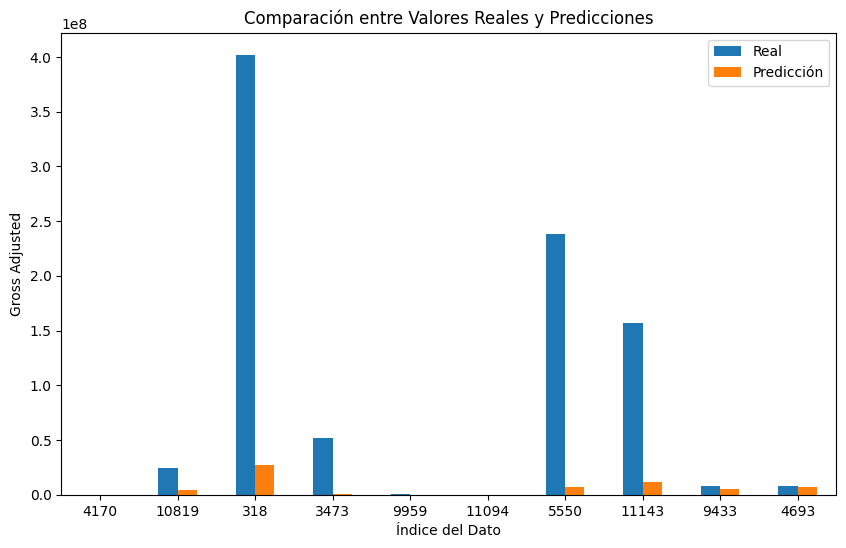

In [112]:
# Asumiendo que 'predictions' y 'y_test' ya están definidos y que 'y_test' es un pandas Series o array de numpy
predictions = model.predict(X_test).flatten()
predictions_transformed = np.expm1(predictions[:10])
real_values = np.expm1(y_test[:10])

# Crear un DataFrame para visualizar ambos lado a lado
comparison_df = pd.DataFrame({'Real': real_values, 'Predicción': predictions_transformed})
comparison_df.plot(kind='bar', figsize=(10, 6))

# Añadir detalles al gráfico
plt.title('Comparación entre Valores Reales y Predicciones')
plt.xlabel('Índice del Dato')
plt.ylabel('Gross Adjusted')
plt.xticks(rotation=0)
plt.legend()
plt.show()

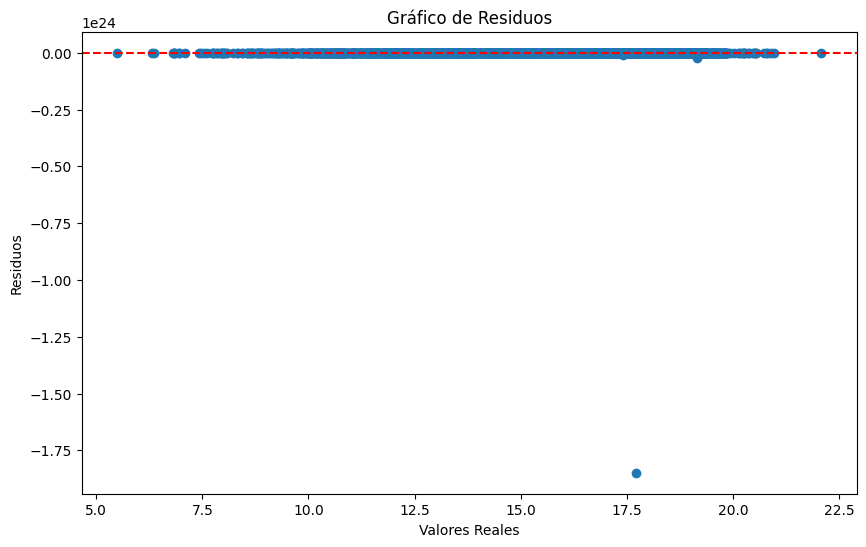

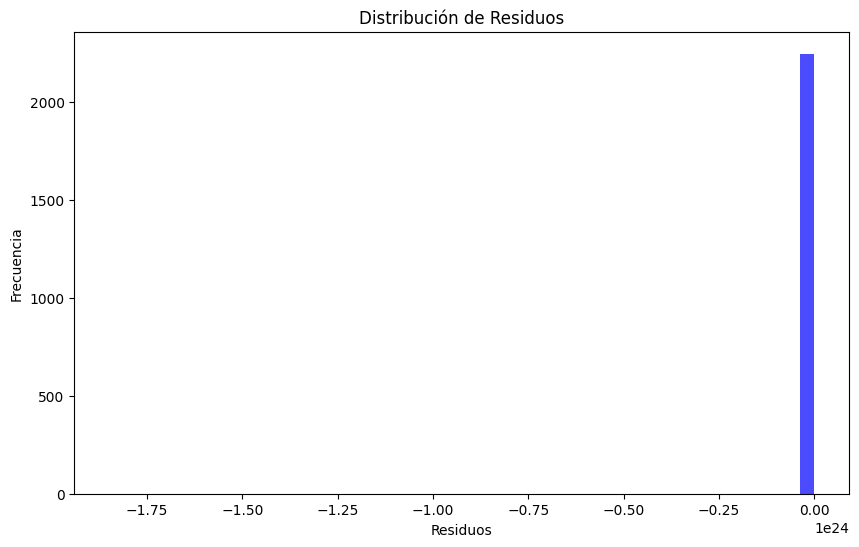

In [113]:
import matplotlib.pyplot as plt

# Calcular los residuos
residuos = y_test - np.expm1(predictions.flatten())

# Gráfico de residuos
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuos)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Reales')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.show()

# Histograma de residuos
plt.figure(figsize=(10, 6))
plt.hist(residuos, bins=50, alpha=0.7, color='blue')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Distribución de Residuos')
plt.show()



In [114]:
# Calcular los residuos
residuos = y_test - np.expm1(predictions.flatten())

# Convertir los residuos a un DataFrame para facilitar la manipulación
residuos_df = pd.DataFrame({'Real': y_test, 'Prediccion': np.expm1(predictions.flatten()), 'Residuo': residuos})

# Ordenar por el valor absoluto de los residuos para encontrar los más grandes
residuos_df['Residuo_abs'] = residuos_df['Residuo'].abs()
residuos_df.sort_values(by='Residuo_abs', ascending=False, inplace=True)

# Mostrar los puntos con los residuos más grandes
print(residuos_df.head())


            Real    Prediccion       Residuo   Residuo_abs
5517   17.720861  1.848540e+24 -1.848540e+24  1.848540e+24
1623   19.156277  2.293908e+22 -2.293908e+22  2.293908e+22
6355   17.405252  8.589484e+21 -8.589484e+21  8.589484e+21
700    20.909036  1.429003e+10 -1.429003e+10  1.429003e+10
10312  20.795284  1.109270e+10 -1.109270e+10  1.109270e+10


 Add Rank directors and stars

In [115]:
directors_summary = movies_df.groupby('main_director').agg(
    movies=('main_director', 'size'),
    rating_avg=('Weighted_Rating', 'mean'),
    popularity_avg=('popularity', 'max')
).reset_index()


new_weighted_score = 0.60* directors_summary['rating_avg'] + 0.30 * directors_summary['popularity_avg'] + 0.10*directors_summary['movies']

directors_summary['combined_score_weighted'] = new_weighted_score

#directors_summary['combined_score'] = (directors_summary['rating_avg'] + directors_summary['popularity_avg']) / 2

directors_summary['rank'] = directors_summary['combined_score_weighted'].rank(method='max', ascending=False)

directors_summary = directors_summary.sort_values(by='rank', ascending=True)

directors_summary#.loc[directors_summary['director'] == 'J.J. Abrams']

,main_director,movies,rating_avg,popularity_avg,combined_score_weighted,rank
259,Andy Serkis,2,6.507175,4497.836,1353.455105,1.0
1189,Destin Daniel Cretton,2,7.251405,3641.782,1097.085443,2.0
2064,Jared Bush,1,7.200260,2782.527,839.178256,3.0
753,Chloé Zhao,1,6.302121,2293.820,692.027272,4.0
1164,Denis Villeneuve,7,7.825647,2056.585,622.370888,5.0
...,...,...,...,...,...,...
4788,Wajahat Rauf,1,2.815894,0.600,1.969536,4964.0
3531,Pat Necerato,1,2.200000,1.691,1.927300,4965.0
2289,Joey Evans,1,2.454545,0.841,1.825027,4966.0
379,Augusto Tamayo San Román,1,1.897895,1.780,1.772737,4967.0
